In [32]:
import pandas as pd
import matplotlib.dates as mdates

In [33]:
# read data
data = pd.read_csv(r"../Data/Aggregated_Final_Data.csv")

In [34]:
# # make sweetviz report
# import sweetviz as sv

# report = sv.analyze(data)

# # save report
# report.show_html("../response_variable/report.html")

**Linear Regression Implementation**

In [35]:
# linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


data.set_index("date_dt", inplace=True)
data.index = pd.to_datetime(data.index)
data = data.dropna()

In [36]:
from sklearn.metrics import mean_squared_error
import joblib


# cumulative sum for last 100 days of news sentiment
data["total_news_score_lag_100_sum"] = data["total_news_score"].rolling(100).sum()
data = data.dropna()

# Featues chosen based on pearson correlation
cols = [
    "stoch_%K",
    "stoch_%D",
    "S&P500 Return",
    "rsi",
    "negative_count",
    "positive_count",
    "total_news_score",
    "negative_avg_score",
    "positive_avg_score",
    "btc_signal",
    "signal",
    "total_news_score_lag_100_sum",
    "Daily Return",
]
X = data[cols].drop(columns=["Daily Return"])
y = data["Daily Return"]

split_date = "2023-03-01"
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r_squared = model.score(X_test, y_test)
print(f"R Squared: {r_squared}")

# print adjusted r squared
n = X_test.shape[0]
p = X_test.shape[1]
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
print(f"Adjusted R Squared: {adj_r_squared}")

# save model
joblib.dump(model, "../Modeling/models/LR_model_ideal.pkl")

Mean Squared Error: 0.00047884650002640277
R Squared: 0.4353432957139304
Adjusted R Squared: 0.3976995154281925


['../Modeling/models/LR_model_ideal.pkl']

In [37]:
# make a dataframe with y_test and y_pred
results = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

# compute residuals
results["residuals"] = results["y_test"] - results["y_pred"]

# save results
results.to_csv("../Modeling/models/LR_results_ideal.csv")

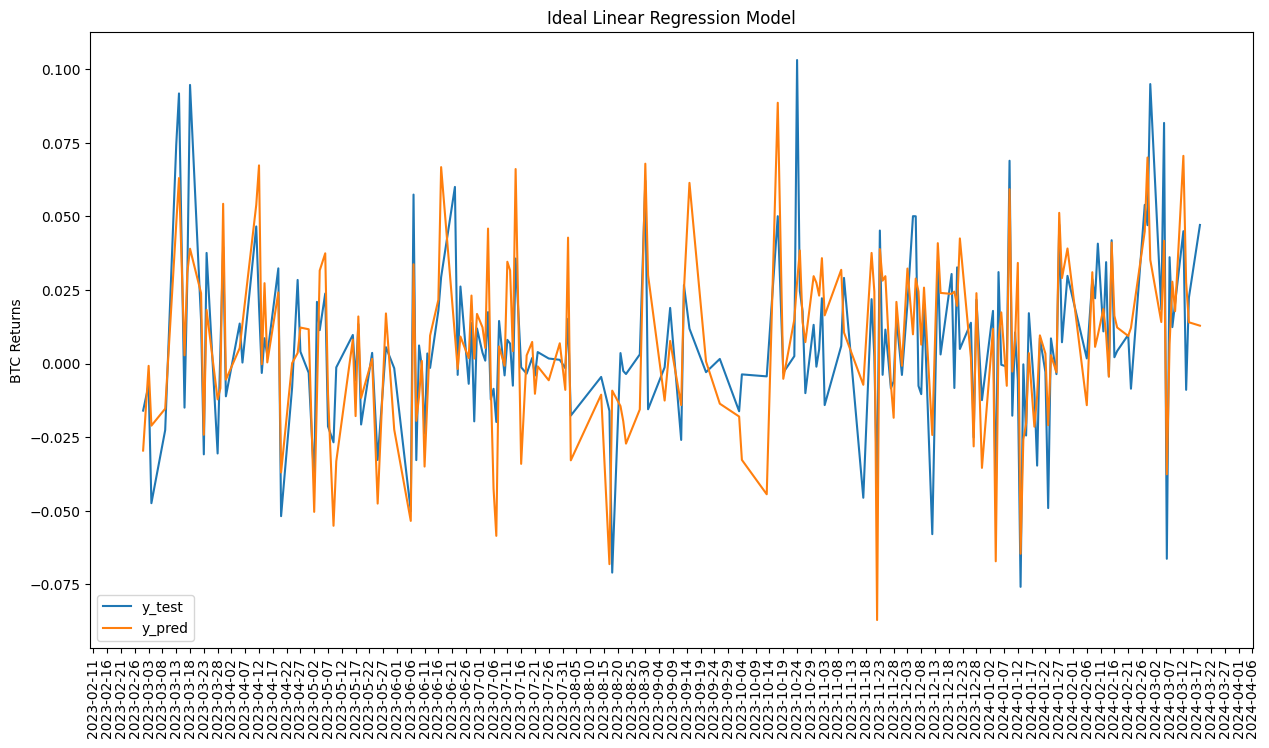

In [38]:
# plot results
import matplotlib.pyplot as plt

plt.plot(results["y_test"], label="y_test")
plt.plot(results["y_pred"], label="y_pred")
plt.legend()
plt.title("Ideal Linear Regression Model")
plt.xticks(rotation=90)
plt.gcf().set_size_inches(15, 8)
# Set x-axis major ticks to occur every 300 days.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.ylabel("BTC Returns")
plt.show()

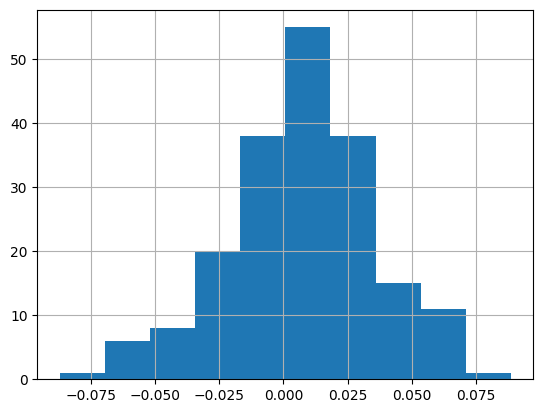

In [39]:
# plot hist fot y_pred
results["y_pred"].hist()
plt.show()

<Axes: >

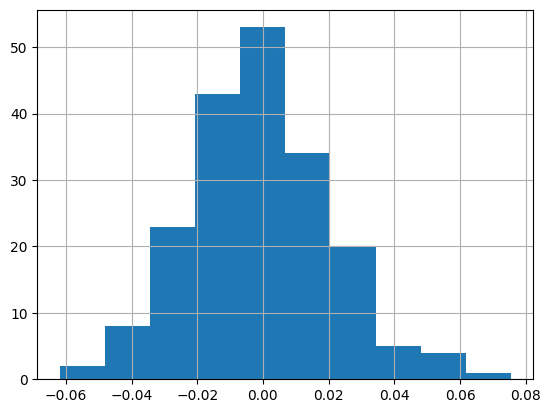

In [40]:
results["residuals"].hist()

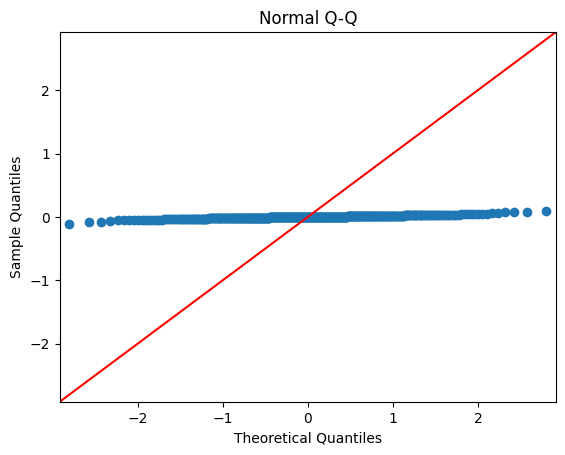

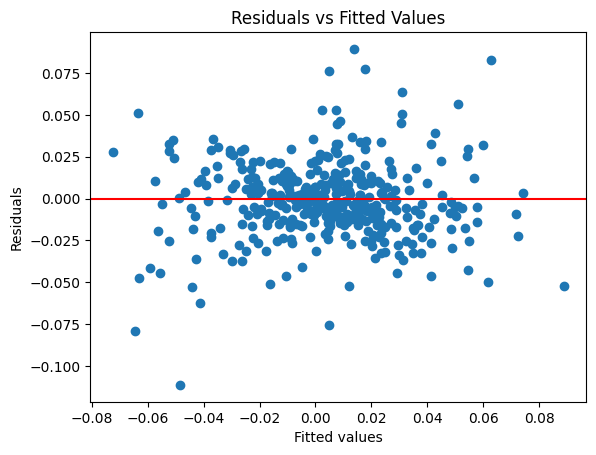

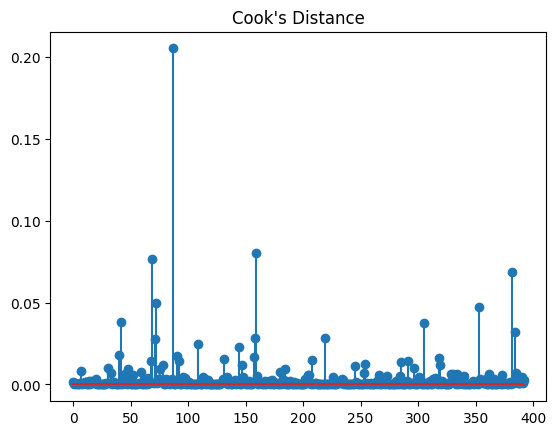

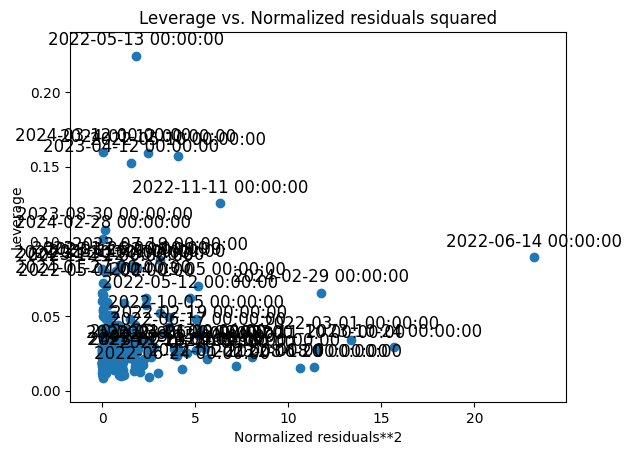

<Figure size 1000x1000 with 0 Axes>

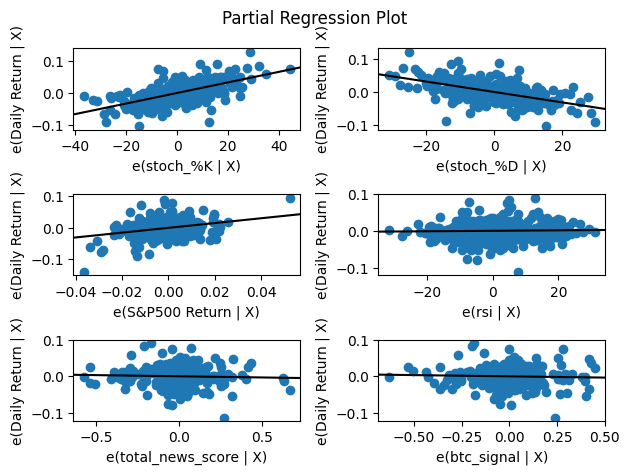

<Figure size 1000x1000 with 0 Axes>

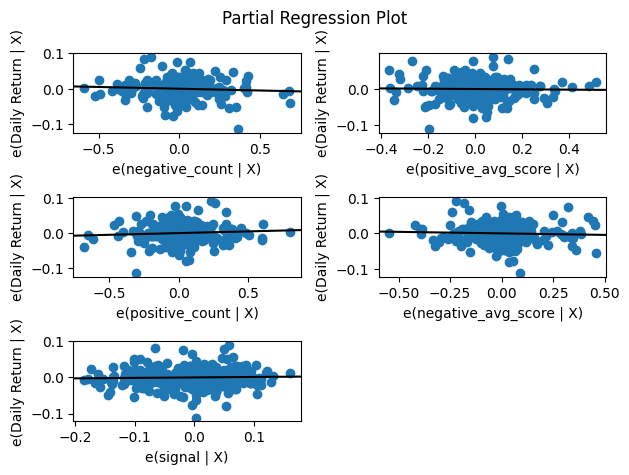

In [41]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Fit your model
model = sm.OLS(y, X)
results = model.fit(cov_type="HC3")

# Get predicted values
y_pred = results.predict(X)

# Calculate residuals
residuals = y - y_pred

# Create a Q-Q plot of the residuals
sm.qqplot(results.resid, line="45")
plt.title("Normal Q-Q")
plt.show()

# Create a scatter plot
plt.scatter(y_pred, residuals)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.axhline(y=0, color="r", linestyle="-")  # Add a horizontal line at y = 0
plt.title("Residuals vs Fitted Values")
plt.show()

# create a cooks distance plot
influence = results.get_influence()
cooks_distance = influence.cooks_distance[0]
plt.stem(range(len(cooks_distance)), cooks_distance)
plt.title("Cook's Distance")
plt.show()

# create a leverage plot
from statsmodels.graphics.regressionplots import plot_leverage_resid2

plot_leverage_resid2(results)

# create a partial regression plot
from statsmodels.graphics.regressionplots import plot_partregress_grid

plt.figure(figsize=(10, 10))
# choose the variables you want to plot
plot_partregress_grid(
    results,
    ["stoch_%K", "stoch_%D", "S&P500 Return", "rsi", "total_news_score", "btc_signal"],
)
plt.tight_layout()

plt.show()

# now plot the other variables
plt.figure(figsize=(10, 10))
plot_partregress_grid(
    results,
    [
        "negative_count",
        "positive_avg_score",
        "positive_count",
        "negative_avg_score",
        "signal",
    ],
)
plt.tight_layout()

plt.show()

In [42]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Daily Return   R-squared (uncentered):                   0.577
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                              26.05
Date:                Tue, 02 Apr 2024   Prob (F-statistic):                    1.20e-42
Time:                        08:59:27   Log-Likelihood:                          926.44
No. Observations:                 393   AIC:                                     -1829.
Df Residuals:                     381   BIC:                                     -1781.
Df Model:                          12                                                  
Covariance Type:                  HC3                                                  
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
stoch_%K                         0.0017      0.000     12.625      0.000       0.001       0.002
stoch_%D                        -0.0016      0.000    -11.205      0.000      -0.002      -0.001
S&P500 Return                    0.7611      0.214      3.564      0.000       0.343       1.180
rsi                           6.382e-05   9.61e-05      0.664      0.507      -0.000       0.000
negative_count                  -0.0100      0.010     -1.013      0.311      -0.029       0.009
positive_count                   0.0097      0.009      1.141      0.254      -0.007       0.026
total_news_score                -0.0064      0.010     -0.665      0.506      -0.025       0.012
negative_avg_score              -0.0085      0.012     -0.718      0.473      -0.032       0.015
positive_avg_score              -0.0042      0.013     -0.331      0.741      -0.029       0.021
btc_signal                      -0.0069      0.011     -0.635      0.525      -0.028       0.014
signal                           0.0128      0.018      0.731      0.465      -0.022       0.047
total_news_score_lag_100_sum  8.623e-07   2.98e-05      0.029      0.977   -5.75e-05    5.92e-05
==============================================================================
Omnibus:                       30.757   Durbin-Watson:                   2.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.307
Skew:                           0.051   Prob(JB):                     2.27e-28
Kurtosis:                       5.786   Cond. No.                     1.09e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC3)
[3] The condition number is large, 1.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Random Forest Implementatin**

Mean Squared Error: 5.652084925014892e-06
R Squared: 0.9933350506980255


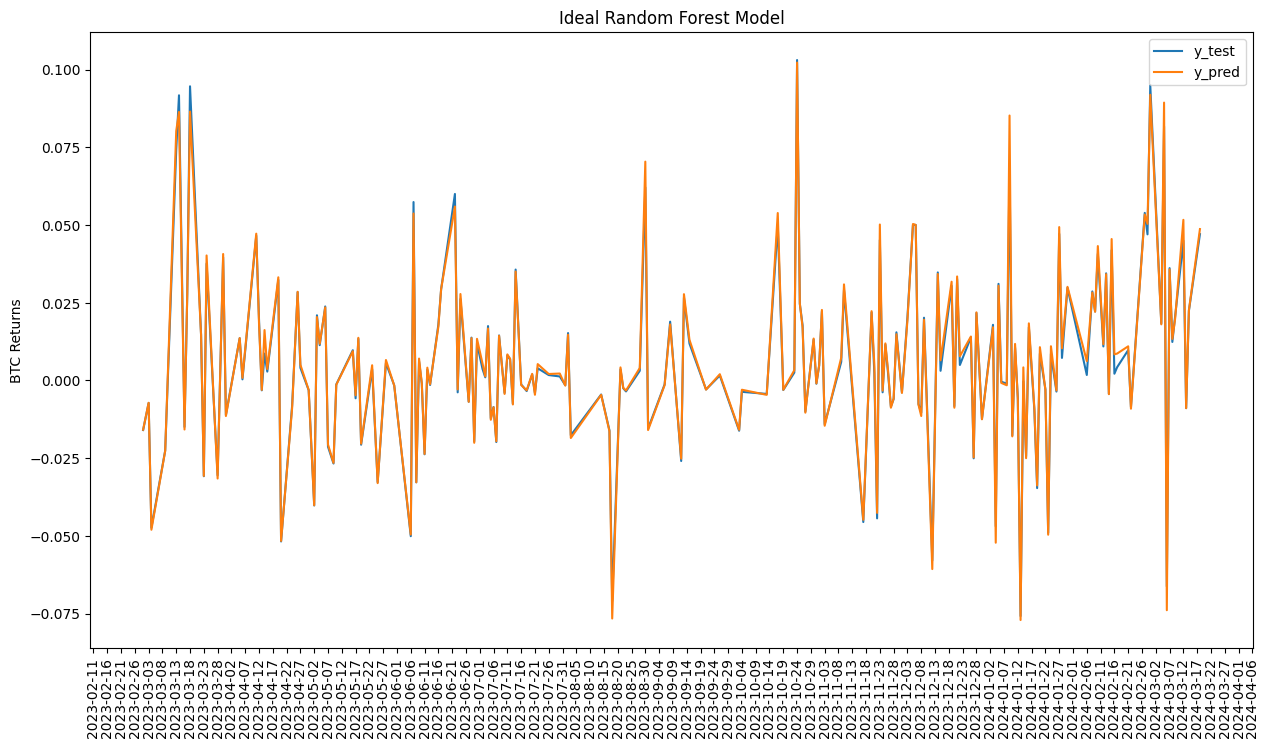

Feature ranking:
1. Relative_Intraday_Price_Change (0.9120720490334729)
2. close_open (0.04201771754074184)
3. Parkinson_Volatility (0.01718983296458141)
4. rsi (0.0037804430048287477)
5. coinbase_total_news_score (0.0031006696537131838)
6. neutral_avg_score (0.0015497966230072207)
7. Upper Band (0.0015292149825135064)
8. S&P500 Return (0.0010427000642264086)
9. DGS10 (0.000739579626616934)
10. ATR (0.0007147704675023199)
11. total_news_count (0.0007127364540486335)
12. TWITTER_NEG_SENTIMENT_COUNT (0.0007086440127576945)
13. total_news_score (0.0006685443849297191)
14. stoch_%D (0.0006521469975008644)
15. TWITTER_PUBLICATION_COUNT (0.0005753934190830671)
16. coinbase_negative_count (0.0005634526916945663)
17. S&P_Return_lag2 (0.0005522067582723591)
18. TWITTER_NEUTRAL_SENTIMENT_CNT (0.0005148008704093912)
19. Low (0.0005065215387649641)
20. VIX Close (0.0004934278039912813)
21. NEWS_SENTIMENT_DAILY_AVG (0.00048514501218344244)
22. Volume (0.0004788476231585619)
23. total_news_score_lag

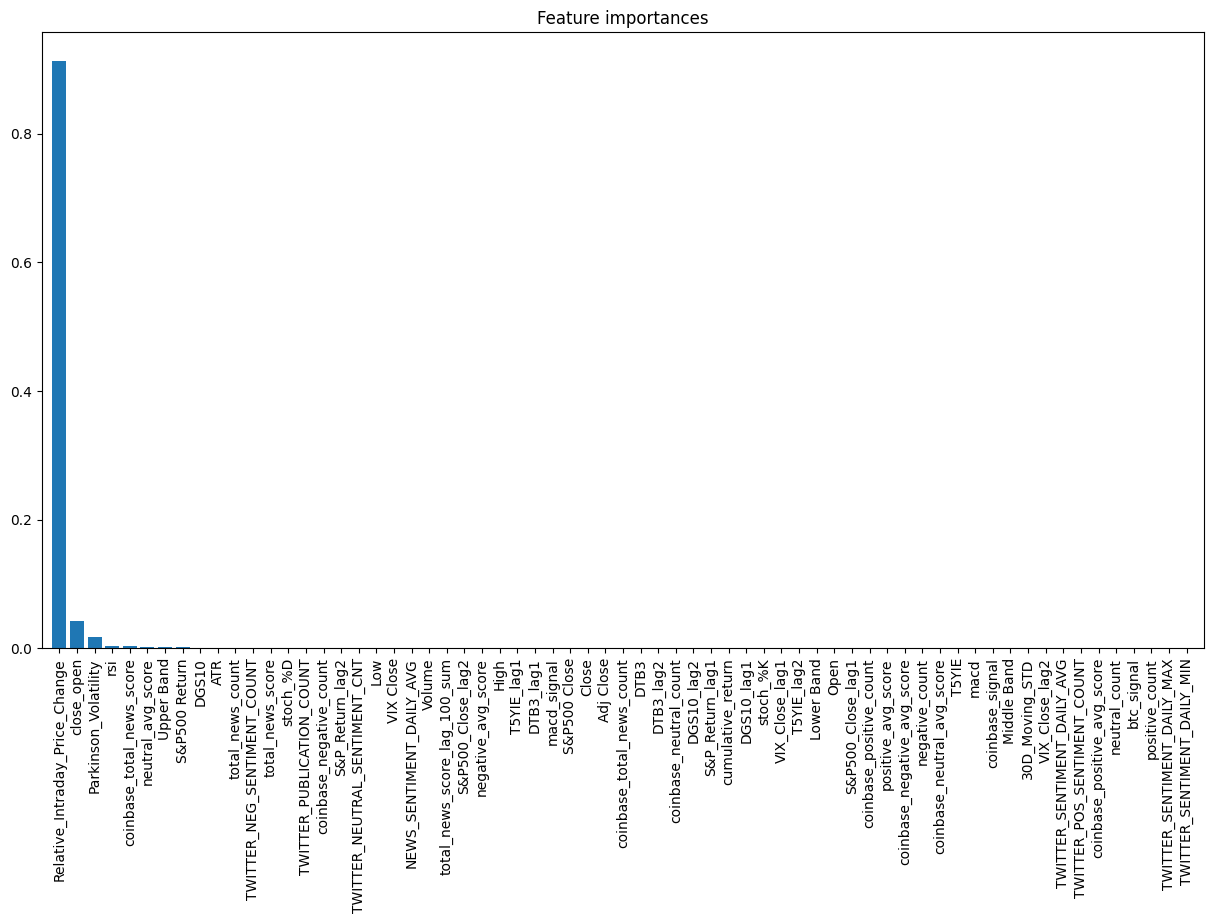

In [43]:
# random forest model
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# fit model
model = RandomForestRegressor()

data = data.dropna(subset=["Daily Return"])

X = data.drop(columns=["Daily Return"])

# drop signal column
X = X.drop(columns=["signal"])

y = data["Daily Return"]


split_date = "2023-03-01"
X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r_squared = model.score(X_test, y_test)
print(f"R Squared: {r_squared}")

# save model
joblib.dump(model, "../Modeling/models/ideal_RF/model_random_forest.pkl")

# make a dataframe with y_test and y_pred
results = pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

# compute residuals
results["residuals"] = results["y_test"] - results["y_pred"]

# save results
results.to_csv("../Modeling/models/ideal_RF/results_random_forest.csv")

# plot results
plt.plot(results["y_test"], label="y_test")
plt.plot(results["y_pred"], label="y_pred")

plt.legend()
plt.title("Ideal Random Forest Model")
plt.xticks(rotation=90)
plt.gcf().set_size_inches(15, 8)
# Set x-axis major ticks to occur every 300 days.
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.ylabel("BTC Returns")

plt.show()

# feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {X.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.gcf().set_size_inches(15, 8)
plt.show()